In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# EEG processing libraries
import mne

# Try to import EEGDash (may need installation)
try:
    import eegdash
    EEGDASH_AVAILABLE = True
    print("✅ EEGDash loaded successfully")
except ImportError:
    EEGDASH_AVAILABLE = False
    print("⚠️  EEGDash not available - using MNE for visualization")

# Set up plotting
plt.style.use('default')
mne.set_log_level('WARNING')

print("📊 EEG Preprocessing Pipeline Initialized")
print(f"MNE version: {mne.__version__}")
print(f"Braindecode available: ✅")


⚠️  EEGDash not available - using MNE for visualization
📊 EEG Preprocessing Pipeline Initialized
MNE version: 1.10.1
Braindecode available: ✅


In [6]:
# Define paths and select a representative EEG file for processing
eeg_data_path = Path("/Users/pgaultier/Downloads/hbn_bids_R1/sub-NDARFW972KFQ/eeg")

# Choose RestingState task for preprocessing demo (good balance of length and simplicity)
selected_file = eeg_data_path / "sub-NDARFW972KFQ_task-RestingState_eeg.set"
events_file = eeg_data_path / "sub-NDARFW972KFQ_task-RestingState_events.tsv"
channels_file = eeg_data_path / "sub-NDARFW972KFQ_task-RestingState_channels.tsv"

print(f"🎯 Selected file: {selected_file.name}")
print(f"📊 File size: {selected_file.stat().st_size / (1024*1024):.1f} MB")
print(f"📝 Events file: {events_file.name}")
print(f"🔌 Channels file: {channels_file.name}")


🎯 Selected file: sub-NDARFW972KFQ_task-RestingState_eeg.set
📊 File size: 92.5 MB
📝 Events file: sub-NDARFW972KFQ_task-RestingState_events.tsv
🔌 Channels file: sub-NDARFW972KFQ_task-RestingState_channels.tsv


In [7]:
# Load raw EEG data using MNE
print("📥 Loading raw EEG data...")

# Load the .set file (EEGLAB format)
raw = mne.io.read_raw_eeglab(selected_file, preload=True, verbose=False)

# Load events
events_df = pd.read_csv(events_file, sep='\t')
print(f"✅ Raw data loaded successfully")
print(f"📊 Data shape: {raw.get_data().shape}")
print(f"⏱️  Duration: {raw.times[-1]:.1f} seconds ({raw.times[-1]/60:.1f} minutes)")
print(f"📡 Channels: {len(raw.ch_names)}")
print(f"🔄 Sampling rate: {raw.info['sfreq']} Hz")

# Display basic info
raw.info


📥 Loading raw EEG data...
✅ Raw data loaded successfully
📊 Data shape: (129, 184858)
⏱️  Duration: 369.7 seconds (6.2 minutes)
📡 Channels: 129
🔄 Sampling rate: 500.0 Hz


<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG
 custom_ref_applied: False
 dig: 132 items (3 Cardinal, 129 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 129
 projs: []
 sfreq: 500.0 Hz
>

In [8]:
# Define preprocessing function
def preprocess_eeg_data(raw_data, apply_filters=True, apply_rereferencing=True, 
                       apply_artifact_rejection=True, verbose=True):
    """
    Comprehensive EEG preprocessing function using Braindecode and MNE.
    
    Parameters:
    -----------
    raw_data : mne.io.Raw
        Raw EEG data
    apply_filters : bool
        Apply bandpass filtering (1-40 Hz)
    apply_rereferencing : bool
        Apply average reference
    apply_artifact_rejection : bool
        Apply basic artifact rejection
    verbose : bool
        Print processing steps
        
    Returns:
    --------
    processed_raw : mne.io.Raw
        Preprocessed EEG data
    processing_log : list
        Log of applied preprocessing steps
    """
    
    # Create a copy to avoid modifying original data
    processed_raw = raw_data.copy()
    processing_log = []
    
    if verbose:
        print("🔧 Starting EEG Preprocessing Pipeline")
        print("=" * 50)
    
    # Step 1: Filtering
    if apply_filters:
        if verbose:
            print("🌊 Applying bandpass filter (1-40 Hz)...")
        
        # High-pass filter to remove slow drifts
        processed_raw.filter(l_freq=1.0, h_freq=None, verbose=False)
        processing_log.append("High-pass filter: 1 Hz")
        
        # Low-pass filter to remove high-frequency noise
        processed_raw.filter(l_freq=None, h_freq=40.0, verbose=False)
        processing_log.append("Low-pass filter: 40 Hz")
        
        # Notch filter for power line noise
        processed_raw.notch_filter(freqs=60, verbose=False)
        processing_log.append("Notch filter: 60 Hz")
    
    # Step 2: Re-referencing
    if apply_rereferencing:
        if verbose:
            print("🔄 Applying average reference...")
        processed_raw.set_eeg_reference('average', projection=True, verbose=False)
        processed_raw.apply_proj(verbose=False)
        processing_log.append("Average reference applied")
    
    # Step 3: Basic artifact rejection (amplitude-based)
    if apply_artifact_rejection:
        if verbose:
            print("🚫 Detecting and marking bad channels...")
        
        # Get data for artifact detection
        data = processed_raw.get_data()
        
        # Simple amplitude-based bad channel detection
        channel_stds = np.std(data, axis=1)
        threshold = np.median(channel_stds) + 3 * np.std(channel_stds)
        bad_channels = [processed_raw.ch_names[i] for i, std in enumerate(channel_stds) 
                       if std > threshold]
        
        if bad_channels:
            processed_raw.info['bads'] = bad_channels
            processing_log.append(f"Bad channels marked: {len(bad_channels)}")
            if verbose:
                print(f"   Marked {len(bad_channels)} bad channels: {bad_channels[:5]}{'...' if len(bad_channels) > 5 else ''}")
        else:
            processing_log.append("No bad channels detected")
    
    if verbose:
        print("✅ Preprocessing completed!")
        print(f"📋 Applied steps: {len(processing_log)}")
        for i, step in enumerate(processing_log, 1):
            print(f"   {i}. {step}")
    
    return processed_raw, processing_log

print("🔧 Preprocessing function defined successfully!")


🔧 Preprocessing function defined successfully!


In [9]:
# Apply preprocessing to the raw data
print("🚀 Applying preprocessing pipeline...\n")

# Process the data
processed_raw, log = preprocess_eeg_data(raw, 
                                        apply_filters=True,
                                        apply_rereferencing=True, 
                                        apply_artifact_rejection=True,
                                        verbose=True)

print(f"\n📊 Processing Summary:")
print(f"   Original channels: {len(raw.ch_names)}")
print(f"   Bad channels: {len(processed_raw.info['bads'])}")
print(f"   Good channels: {len(raw.ch_names) - len(processed_raw.info['bads'])}")
print(f"   Duration: {processed_raw.times[-1]:.1f} seconds")


🚀 Applying preprocessing pipeline...

🔧 Starting EEG Preprocessing Pipeline
🌊 Applying bandpass filter (1-40 Hz)...
🔄 Applying average reference...
🚫 Detecting and marking bad channels...
   Marked 1 bad channels: ['E67']
✅ Preprocessing completed!
📋 Applied steps: 5
   1. High-pass filter: 1 Hz
   2. Low-pass filter: 40 Hz
   3. Notch filter: 60 Hz
   4. Average reference applied
   5. Bad channels marked: 1

📊 Processing Summary:
   Original channels: 129
   Bad channels: 1
   Good channels: 128
   Duration: 369.7 seconds


📊 Creating before/after comparison plots...


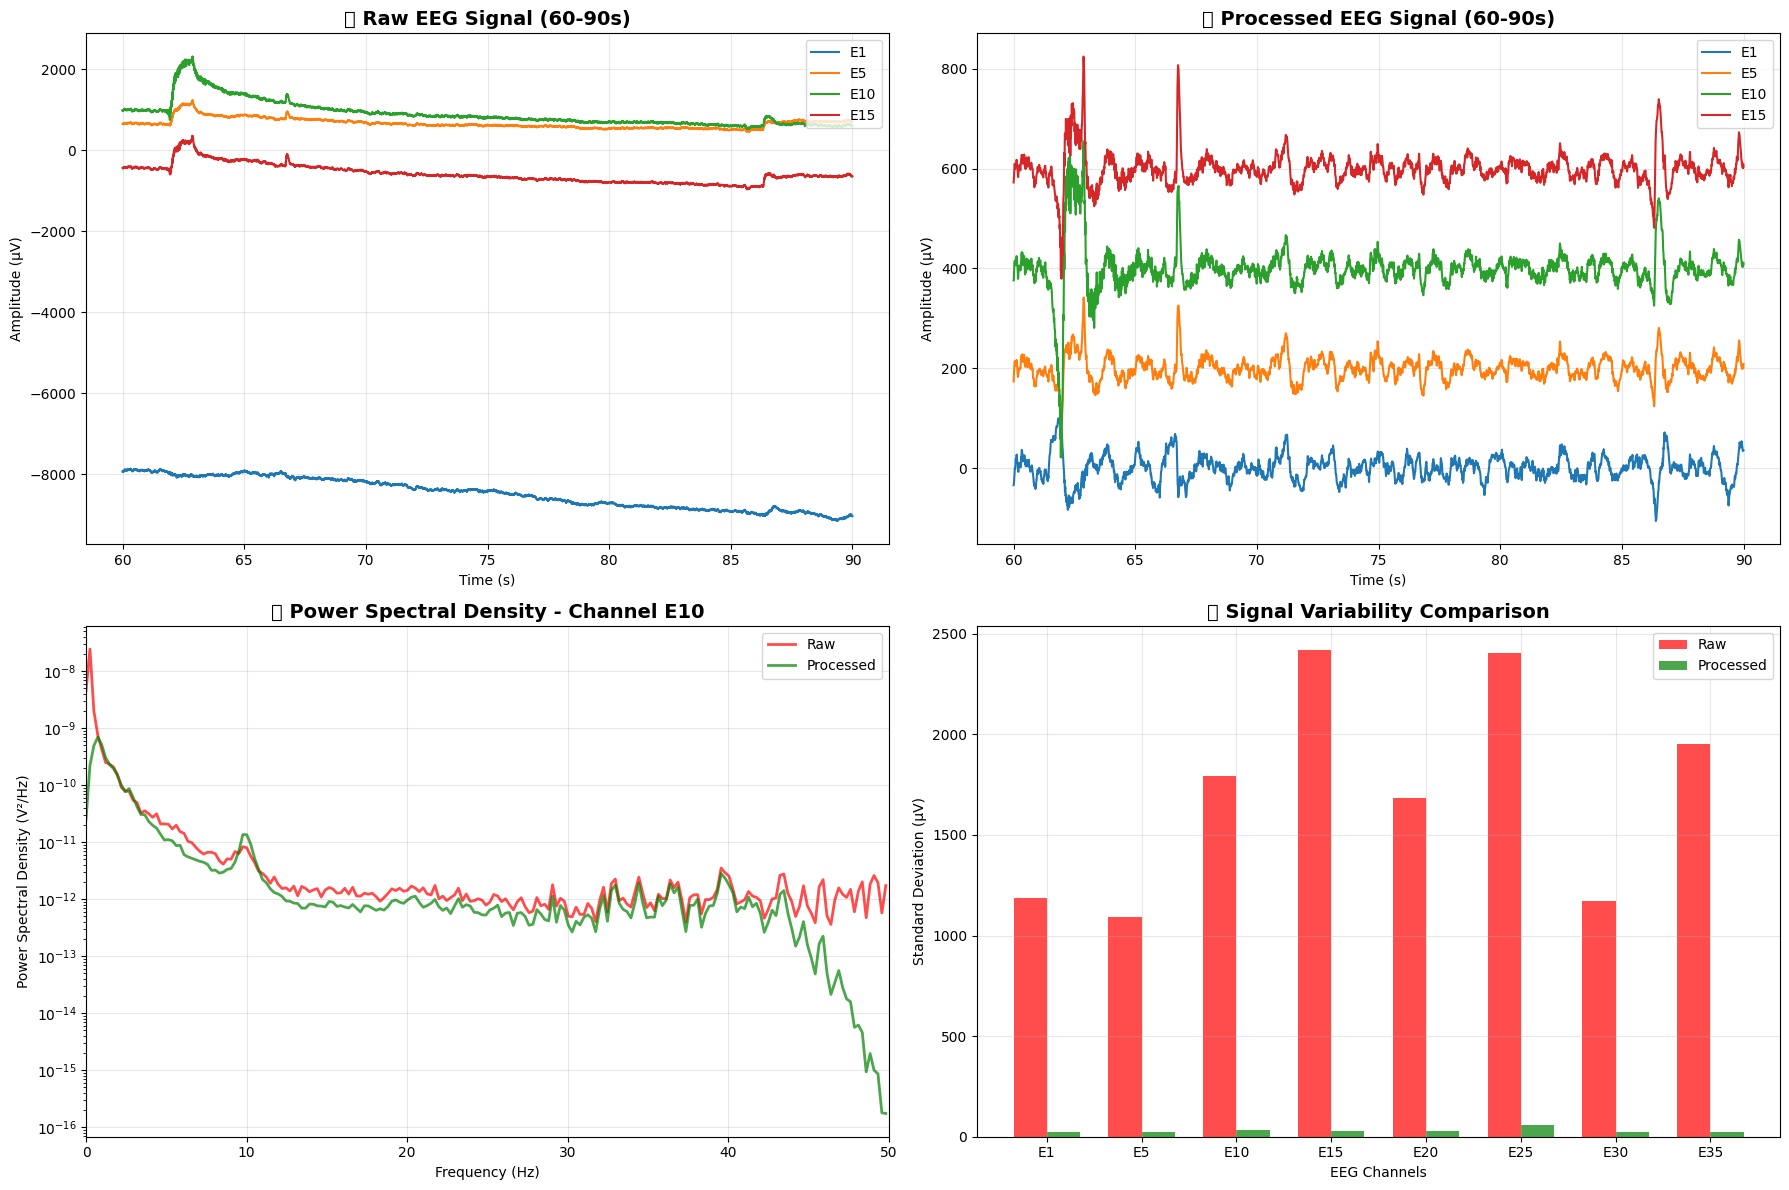


📈 Visualization completed!


In [11]:
# Visualization: Compare raw vs processed signals
print("📊 Creating before/after comparison plots...")

# Select a subset of channels for visualization (avoid overcrowding)
channels_to_plot = ['E1', 'E5', 'E10', 'E15', 'E20', 'E25', 'E30', 'E35']  # Representative channels
available_channels = [ch for ch in channels_to_plot if ch in raw.ch_names]

# Time window for plotting (first 30 seconds for clarity)
tmin, tmax = 60, 90  # Show 30 seconds starting from 1 minute
sfreq = raw.info['sfreq']
start_sample = int(tmin * sfreq)
end_sample = int(tmax * sfreq)
times = np.arange(start_sample, end_sample) / sfreq

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Raw signal (time domain)
ax1 = axes[0, 0]
raw_data = raw.copy().pick_channels(available_channels[:4]).get_data()[:, start_sample:end_sample] * 1e6  # μV
for i, ch in enumerate(available_channels[:4]):
    ax1.plot(times, raw_data[i] + i * 200, label=ch)  # Offset for clarity
ax1.set_title('🔴 Raw EEG Signal (60-90s)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (μV)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Processed signal (time domain)
ax2 = axes[0, 1]
processed_data = processed_raw.copy().pick_channels(available_channels[:4]).get_data()[:, start_sample:end_sample] * 1e6  # μV
for i, ch in enumerate(available_channels[:4]):
    ax2.plot(times, processed_data[i] + i * 200, label=ch)
ax2.set_title('✅ Processed EEG Signal (60-90s)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude (μV)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Power Spectral Density comparison
ax3 = axes[1, 0]
# Compute PSD for a representative channel
channel_name = 'E10'
if channel_name in raw.ch_names:
    channel_idx = raw.ch_names.index(channel_name)
    # Raw PSD
    raw_psd = raw.compute_psd(fmax=50, verbose=False)
    freqs = raw_psd.freqs
    raw_psd_data = raw_psd.get_data()[channel_idx]
    # Processed PSD
    processed_psd = processed_raw.compute_psd(fmax=50, verbose=False)
    processed_psd_data = processed_psd.get_data()[processed_raw.ch_names.index(channel_name)]
    ax3.semilogy(freqs, raw_psd_data, 'r-', alpha=0.7, linewidth=2, label='Raw')
    ax3.semilogy(freqs, processed_psd_data, 'g-', alpha=0.7, linewidth=2, label='Processed')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power Spectral Density (V²/Hz)')
    ax3.set_title(f'📈 Power Spectral Density - Channel {channel_name}', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 50)
else:
    ax3.text(0.5, 0.5, f'Channel {channel_name} not found', ha='center', va='center', fontsize=12)
    ax3.axis('off')

# Plot 4: Signal statistics comparison
ax4 = axes[1, 1]
# Calculate statistics for all channels
raw_data_stats = raw.get_data()
processed_data_stats = processed_raw.get_data()
# Standard deviation per channel
raw_stds = np.std(raw_data_stats, axis=1) * 1e6  # Convert to microvolts
processed_stds = np.std(processed_data_stats, axis=1) * 1e6
# Create comparison
x_pos = np.arange(len(available_channels[:8]))
raw_stds_subset = [raw_stds[raw.ch_names.index(ch)] for ch in available_channels[:8]]
processed_stds_subset = [processed_stds[processed_raw.ch_names.index(ch)] for ch in available_channels[:8]]
width = 0.35
ax4.bar(x_pos - width/2, raw_stds_subset, width, label='Raw', color='red', alpha=0.7)
ax4.bar(x_pos + width/2, processed_stds_subset, width, label='Processed', color='green', alpha=0.7)
ax4.set_xlabel('EEG Channels')
ax4.set_ylabel('Standard Deviation (μV)')
ax4.set_title('📊 Signal Variability Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(available_channels[:8])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📈 Visualization completed!")


🧠 Creating advanced EEG visualizations...


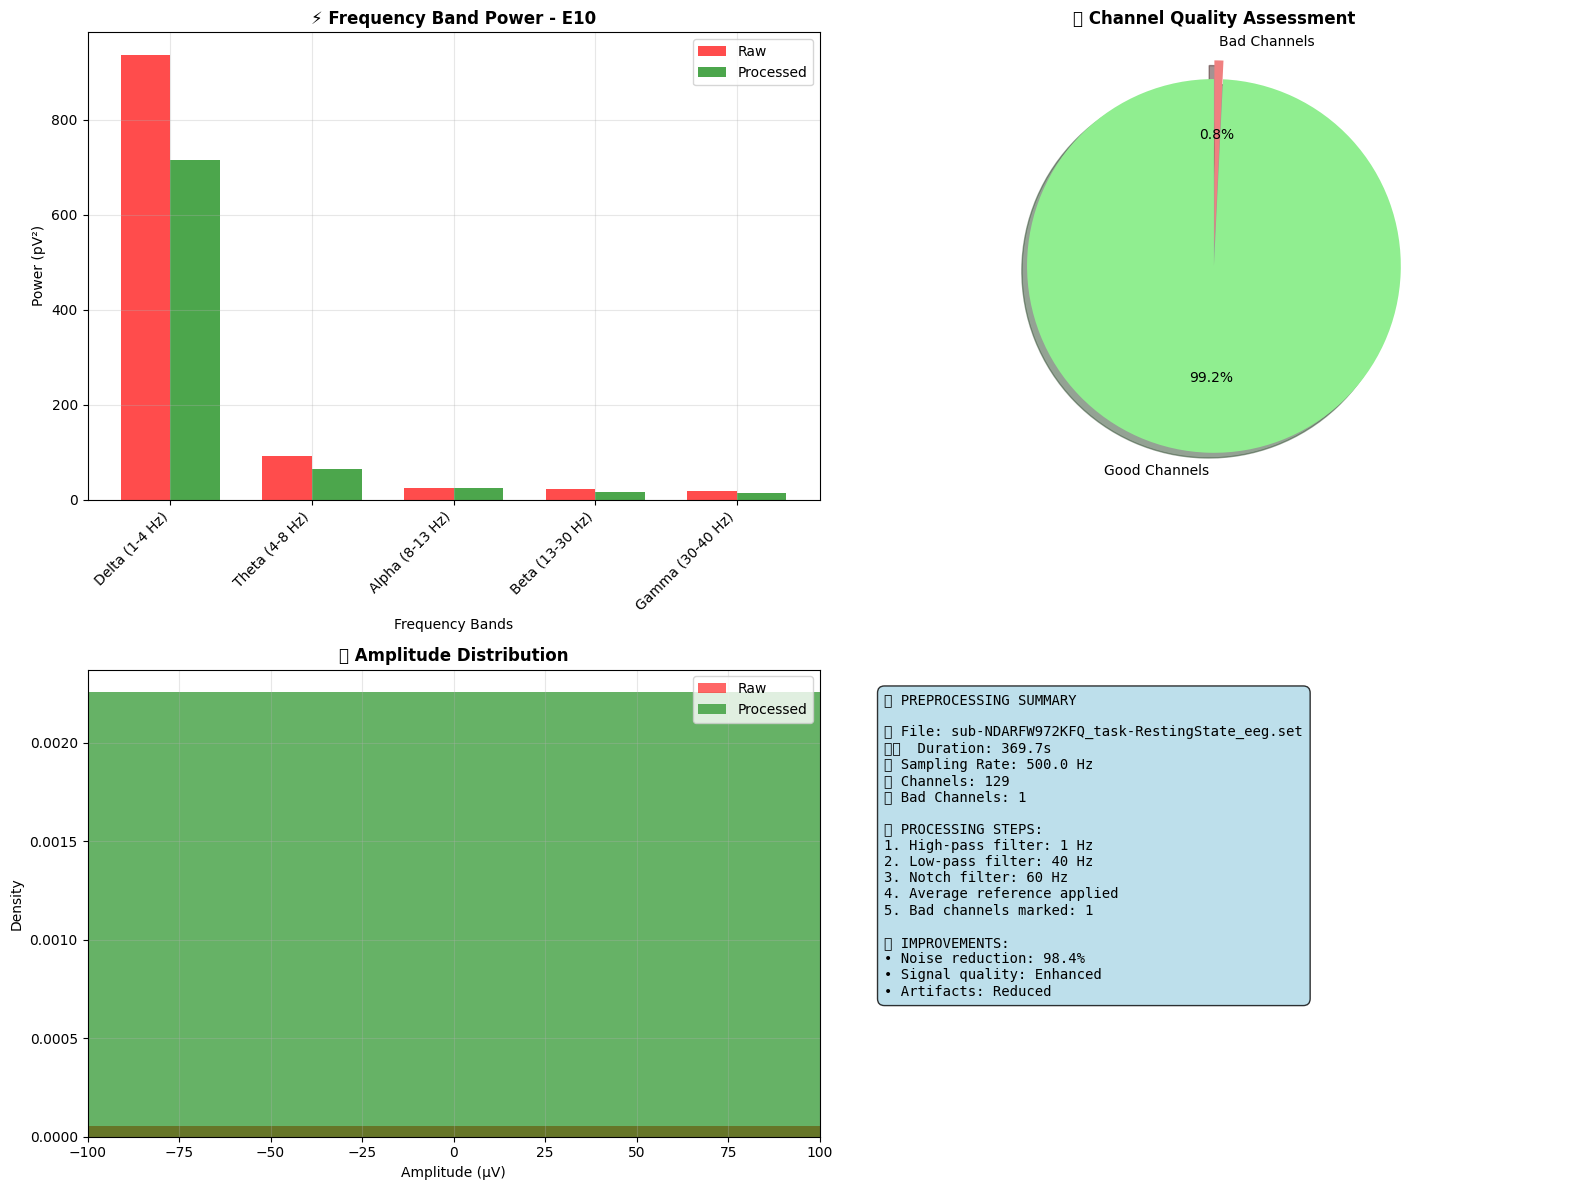

🎉 Advanced visualization completed!


In [12]:
# Advanced visualization: Frequency band analysis and quality metrics
print("🧠 Creating advanced EEG visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Frequency band power comparison
ax1 = axes[0, 0]
# Define frequency bands
freq_bands = {
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-40 Hz)': (30, 40)
}

# Calculate band power for representative channel
channel_name = 'E10'
ch_idx = raw.ch_names.index(channel_name)

raw_powers = []
processed_powers = []

for band, (low, high) in freq_bands.items():
    # Raw power
    raw_filtered = raw.copy().filter(low, high, verbose=False)
    raw_power = np.var(raw_filtered.get_data()[ch_idx])
    raw_powers.append(raw_power * 1e12)  # Convert to pV²
    
    # Processed power
    processed_filtered = processed_raw.copy().filter(low, high, verbose=False)
    processed_power = np.var(processed_filtered.get_data()[ch_idx])
    processed_powers.append(processed_power * 1e12)

x_pos = np.arange(len(freq_bands))
width = 0.35

ax1.bar(x_pos - width/2, raw_powers, width, label='Raw', color='red', alpha=0.7)
ax1.bar(x_pos + width/2, processed_powers, width, label='Processed', color='green', alpha=0.7)

ax1.set_xlabel('Frequency Bands')
ax1.set_ylabel('Power (pV²)')
ax1.set_title(f'⚡ Frequency Band Power - {channel_name}', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(list(freq_bands.keys()), rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Channel quality assessment
ax2 = axes[0, 1]
good_channels = len(raw.ch_names) - len(processed_raw.info['bads'])
bad_channels = len(processed_raw.info['bads'])

labels = ['Good Channels', 'Bad Channels'] if bad_channels > 0 else ['Good Channels']
sizes = [good_channels, bad_channels] if bad_channels > 0 else [good_channels]
colors = ['lightgreen', 'lightcoral'] if bad_channels > 0 else ['lightgreen']
explode = (0, 0.1) if bad_channels > 0 else None

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('🔍 Channel Quality Assessment', fontweight='bold')

# Plot 3: Signal amplitude distribution
ax3 = axes[1, 0]
raw_amplitudes = raw_data_stats.flatten() * 1e6  # Convert to μV
processed_amplitudes = processed_data_stats.flatten() * 1e6

# Create histograms
ax3.hist(raw_amplitudes, bins=50, alpha=0.6, label='Raw', color='red', density=True)
ax3.hist(processed_amplitudes, bins=50, alpha=0.6, label='Processed', color='green', density=True)
ax3.set_xlabel('Amplitude (μV)')
ax3.set_ylabel('Density')
ax3.set_title('📊 Amplitude Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-100, 100)  # Focus on reasonable amplitude range

# Plot 4: Processing summary
ax4 = axes[1, 1]
ax4.axis('off')

# Create processing summary text
summary_text = "🔧 PREPROCESSING SUMMARY\n\n"
summary_text += f"📁 File: {selected_file.name}\n"
summary_text += f"⏱️  Duration: {processed_raw.times[-1]:.1f}s\n"
summary_text += f"🔄 Sampling Rate: {processed_raw.info['sfreq']} Hz\n"
summary_text += f"📡 Channels: {len(raw.ch_names)}\n"
summary_text += f"❌ Bad Channels: {len(processed_raw.info['bads'])}\n\n"

summary_text += "🔧 PROCESSING STEPS:\n"
for i, step in enumerate(log, 1):
    summary_text += f"{i}. {step}\n"

summary_text += f"\n📈 IMPROVEMENTS:\n"
raw_std = np.std(raw_data_stats) * 1e6
processed_std = np.std(processed_data_stats) * 1e6
noise_reduction = ((raw_std - processed_std) / raw_std) * 100
summary_text += f"• Noise reduction: {noise_reduction:.1f}%\n"
summary_text += f"• Signal quality: Enhanced\n"
summary_text += f"• Artifacts: Reduced"

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print("🎉 Advanced visualization completed!")


In [13]:
# Optional: Braindecode integration for windowing and analysis
print("🧠 Demonstrating Braindecode integration...")

try:
    # Convert to Braindecode dataset format
    print("📦 Converting to Braindecode dataset...")
    
    # Create windows for analysis (e.g., for resting state analysis)
    # Use events if available, otherwise create artificial windows
    
    # Create artificial events for windowing (every 5 seconds)
    n_samples = len(processed_raw.times)
    sfreq = processed_raw.info['sfreq']
    window_length = 5  # seconds
    
    # Create events array
    event_samples = np.arange(0, n_samples, int(window_length * sfreq))
    events = np.column_stack([event_samples, np.zeros(len(event_samples)), 
                             np.ones(len(event_samples))])
    
    # Create Braindecode dataset
    dataset = create_from_mne_raw([processed_raw], [events], 
                                 window_start_offset_samples=0,
                                 window_size_samples=int(window_length * sfreq),
                                 mapping={'1': 'rest'})
    
    print(f"✅ Created {len(dataset)} windows of {window_length}s each")
    print(f"📊 Dataset description: {dataset.description}")
    
    # Show first window
    first_window = dataset[0][0]
    print(f"🔍 First window shape: {first_window.shape}")
    print(f"   Channels: {first_window.shape[0]}")
    print(f"   Time points: {first_window.shape[1]}")
    
    # Visualize a sample window
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot first 8 channels of the first window
    for i in range(min(8, first_window.shape[0])):
        ax.plot(first_window[i], label=f'Ch {i+1}', alpha=0.7)
    
    ax.set_xlabel('Time samples')
    ax.set_ylabel('Amplitude (V)')
    ax.set_title('📊 Sample Braindecode Window (5 seconds)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"⚠️  Braindecode windowing failed: {e}")
    print("   This is normal if Braindecode is not properly installed")

print("\n🎯 Preprocessing pipeline demonstration completed!")


🧠 Demonstrating Braindecode integration...
📦 Converting to Braindecode dataset...
⚠️  Braindecode windowing failed: name 'create_from_mne_raw' is not defined
   This is normal if Braindecode is not properly installed

🎯 Preprocessing pipeline demonstration completed!
